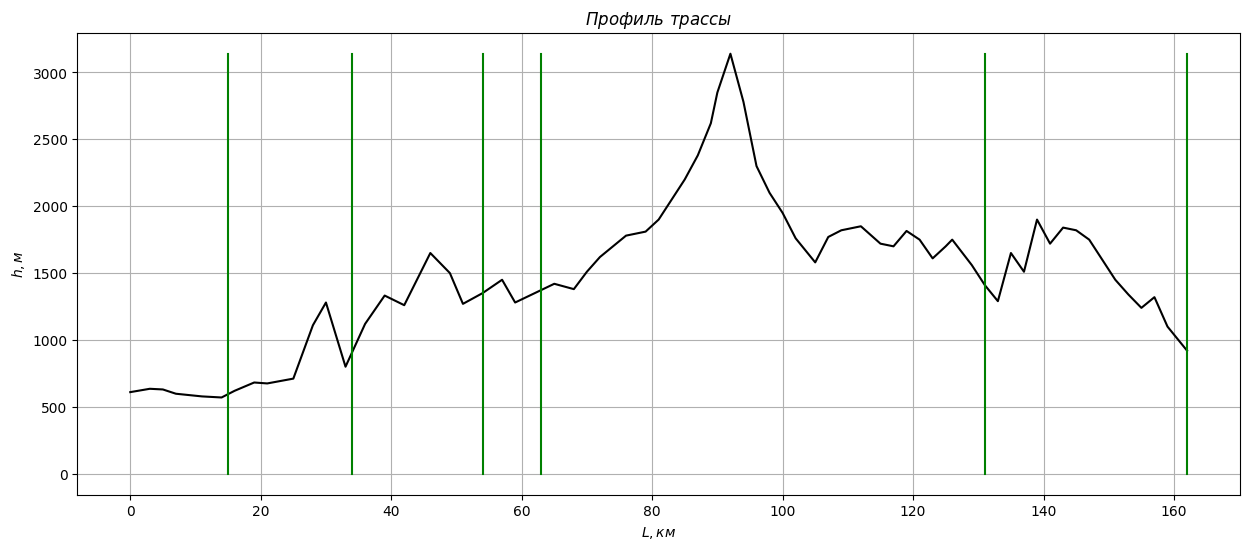

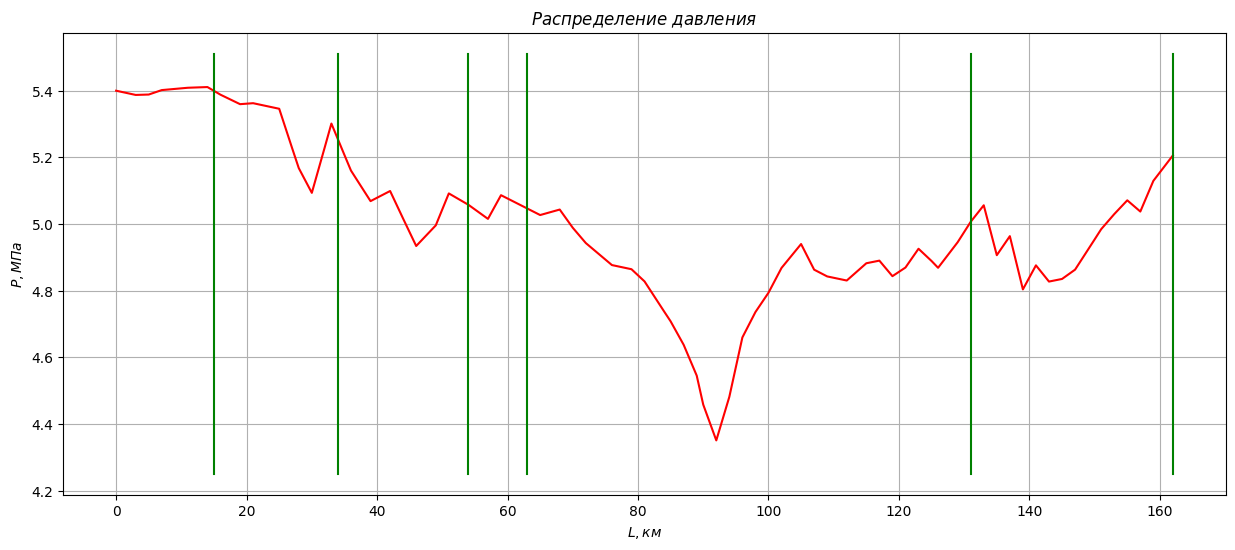

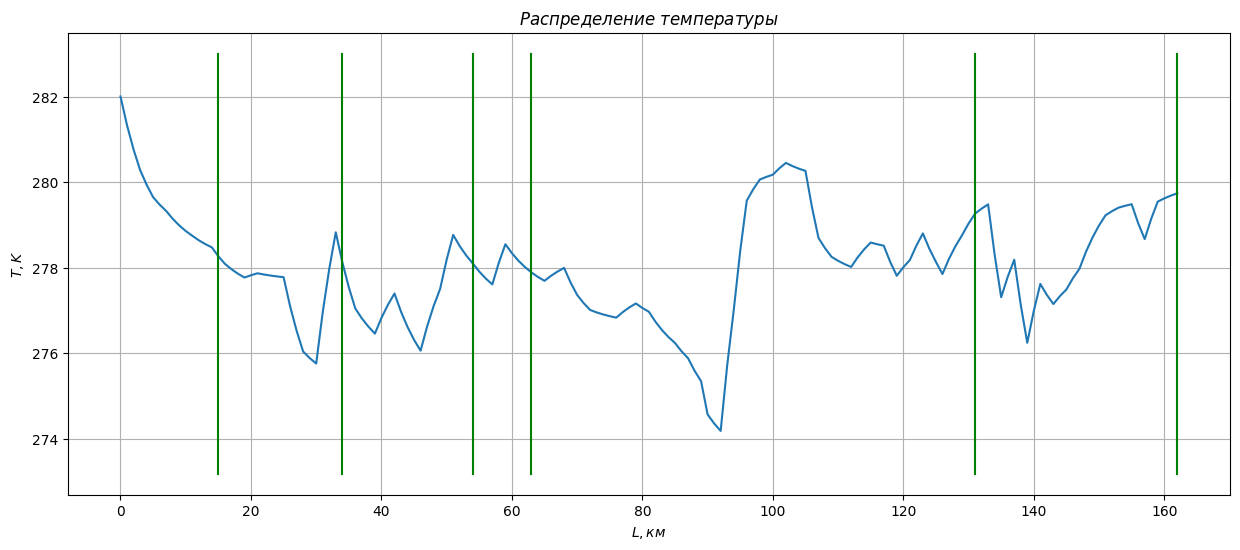

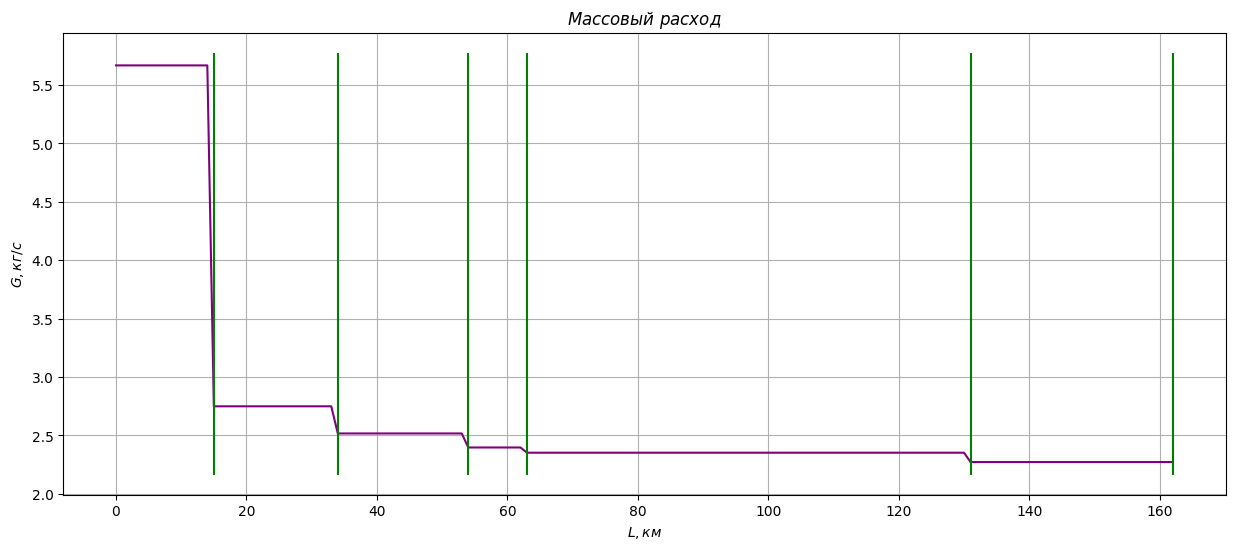

In [2]:
import matplotlib.pyplot as plt
import numpy as np

class PipelineModel:
    def __init__(self, D, sigma, L, mu, P_crit, T_crit, Kt, T_nar, lamda, P0, Cv, T0, g, ro_stan, G_general, G_GDS, x_GDS, x, h, n):
        self.D = D
        self.sigma = sigma
        self.L = L
        self.mu = mu
        self.P_crit = P_crit
        self.T_crit = T_crit
        self.Kt = Kt
        self.T_nar = T_nar
        self.lamda = lamda
        self.P0 = P0
        self.Cv = Cv
        self.T0 = T0
        self.g = g
        self.ro_stan = ro_stan
        self.R = 8314 / self.mu
        self.d = self.D - 2 * self.sigma
        self.S = (np.pi * self.d ** 2) / 4
        self.G = G_general
        self.G_general = G_general
        self.G_GDS = G_GDS
        self.x_GDS = x_GDS

        self.x = x
        self.h = h

        self.n = n
        self.delta_x = self.L / self.n

        self.P = self.P0
        self.T = self.T0
        self.P_list = [self.P / 1000000]
        self.T_list = [self.T]
        self.delta_x_list = [0]
        self.dz_dx_list = [0]
        self.G_list_1 = [self.G_general]

        self.initialize_values()

    def initialize_values(self):
        self.G_list = [self.G_general]
        for i in range(len(self.G_GDS)):
            G_i = self.G_list[i] - self.G_GDS[i]
            self.G_list.append(G_i)

        self.x_j = [[x_GDS[i], x_GDS[i]] for i in range(1, len(x_GDS))]
        self.h_j = [[0, max(h)] for i in range(1, len(x_GDS))]

    def calculate_parameters(self):
        for j in range(1, self.n + 1):
            current_delta_x = j * self.delta_x
            self.delta_x_list.append(current_delta_x / 1000)
            dz_dx = self.calculate_dz_dx(current_delta_x)
            self.dz_dx_list.append(dz_dx)
            G = self.calculate_G(current_delta_x)
            self.G_list_1.append(G)

            z = 1 - 0.4273 * (self.P / self.P_crit) * (self.T / self.T_crit) ** (-3.668)
            ro = self.P / (z * self.R * self.T)

            dz_dp_t = -(0.4273 / self.P_crit) * (self.T / self.T_crit) ** (-3.668)
            dz_dt_p = 0.4273 * 3.668 * (self.P / self.P_crit) * (self.T ** (-4.668) / self.T_crit ** (-3.668))

            a1, b1, c1 = self.calculate_a1_b1_c1(G, z, ro, dz_dp_t, dz_dx)
            a2, b2, c2 = self.calculate_a2_b2_c2(z, ro, dz_dt_p, dz_dp_t)

            detA = a1 * b2 - a2 * b1
            detA1 = c1 * b2 - c2 * b1
            detA2 = a1 * c2 - a2 * c1

            dp_dx = detA1 / detA
            dt_dx = detA2 / detA

            self.P += dp_dx * (self.L / self.n)
            self.T += dt_dx * (self.L / self.n)

            self.P_list.append(self.P / 1000000)
            self.T_list.append(self.T)

        self.p_j = [[min(self.P_list) - 0.1, max(self.P_list) + 0.1] for i in range(1, len(x_GDS))]
        self.t_j = [[min(self.T_list) - 1, max(self.T_list) + 1] for i in range(1, len(x_GDS))]
        self.g_j = [[min(self.G_list_1) - 0.1, max(self.G_list_1) + 0.1] for i in range(1, len(x_GDS))]

    def calculate_dz_dx(self, current_delta_x):
        for i in range(len(self.x) - 1):
            if self.x[i] * 1000 < current_delta_x <= self.x[i + 1] * 1000:
                return (self.h[i + 1] - self.h[i]) / (self.x[i + 1] - self.x[i]) / 1000
        return 0

    def calculate_G(self, current_delta_x):
        for i in range(len(self.x_GDS) - 1):
            if self.x_GDS[i] * 1000 <= current_delta_x < self.x_GDS[i + 1] * 1000:
                return self.G_list[i]
        return self.G_list[-1]

    def calculate_a1_b1_c1(self, G, z, ro, dz_dp_t, dz_dx):
        a1 = (1 / (G / self.S) ** 2) - (z * self.R * self.T / self.P ** 2) * (1 - (self.P / z) * dz_dp_t)
        b1 = (z * self.R / self.P) * (1 + (self.T / z) * dz_dp_t)
        c1 = -(1 / (G / self.S) ** 2) * ((self.lamda * (G / self.S) ** 2 / (2 * self.d * ro)) + ro * self.g * dz_dx)
        return a1, b1, c1

    def calculate_a2_b2_c2(self, z, ro, dz_dt_p, dz_dp_t):
        a2 = -(z * self.R * self.T / self.P) * (1 + (self.T / z) * dz_dt_p)
        b2 = self.Cv + (z * self.R * (1 + (self.T / z) * dz_dt_p) ** 2) / (1 - (self.P / z) * dz_dp_t)
        c2 = -(4 * (self.Kt / self.d) * (self.T - self.T_nar)) / (self.G / self.S) + (self.lamda / 2 * self.d) * ((self.G / self.S) ** 2 / ro ** 2)
        return a2, b2, c2

    def plot_h(self):
        plt.figure(figsize=(15, 6))
        plt.plot(self.x, self.h, color='black')
        for i in range(len(self.x_j)):
            plt.plot(self.x_j[i], self.h_j[i], color='green')
        plt.xlabel(r'$L, км$')
        plt.ylabel(r'$h, м$')
        plt.title(r'$  Профиль \ трассы  $')
        plt.grid(True)
        plt.show()

    def plot_P(self):
        plt.figure(figsize=(15, 6))
        plt.plot(self.delta_x_list, self.P_list, color='red')
        for i in range(len(self.x_j)):
            plt.plot(self.x_j[i], self.p_j[i], color='green')
        plt.xlabel(r'$L, км$')
        plt.ylabel(r'$P, МПа$')
        plt.title(r'$  Распределение \ давления  $')
        plt.grid(True)
        plt.show()

    def plot_T(self):
        plt.figure(figsize=(15, 6))
        plt.plot(self.delta_x_list, self.T_list)
        for i in range(len(self.x_j)):
            plt.plot(self.x_j[i], self.t_j[i], color='green')
        plt.xlabel(r'$L, км$')
        plt.ylabel(r'$T, K$')
        plt.title(r'$  Распределение \ температуры  $')
        plt.grid(True)
        plt.show()

    def plot_G(self):
        plt.figure(figsize=(15, 6))
        plt.plot(self.delta_x_list, self.G_list_1, color='purple')
        for i in range(len(self.x_j)):
            plt.plot(self.x_j[i], self.g_j[i], color='green')
        plt.xlabel(r'$L, км$')
        plt.ylabel(r'$G, кг/с$')
        plt.title(r'$  Массовый \ расход  $')
        plt.grid(True)
        plt.show()

# Исходные данные
D = 0.426 #the outer diameter of the pipe (m)
sigma = 0.01 #pipe wall thickness (m)
L = 162 * 1000 #length of the gas pipeline (m)
mu = 17.0353 #molar mass of the gas (kg/kmol)
P_crit = 4.579 * 1000000 #critical gas pressure (MPa)
T_crit = 196.3161 #critical gas temperature (K)
Kt = 2 #heat transfer coefficient (W/(m^2*K))
T_nar = 5 + 273 #ambient temperature (K)
lamda = 0.01 #coefficient of hydraulic resistance (dimensionless value)
P0 = 5.4 * 1000000 #pressure at the beginning of the gas pipeline (MPa)
Cv = 2000 #isochoric heat capacity (J/mol*K)
T0 = 9 + 273 #gas temperature at the beginning of the pipeline (K)
g = 9.81 #acceleration of free fall (m/s^2)
ro_stan = 0.7086 #gas density under standard conditions (кг/м^3)

G_general = 5.6688 #total mass consumption (kg/s)
G_GDS = [2.919432, 0.2324208, 0.12017856, 0.04478352, 0.07993008] #gas consumption at each gas distribution station (kg/s)
x_GDS = [0, 15, 34, 54, 63, 131, 162] #location of gas distribution stations along the length of the gas pipeline (km)

#gas pipeline points (km)
x = [0, 3, 5, 7, 11, 14, 16, 19, 21, 25, 28, 30, 33, 36, 39, 42, 46, 49, 51, 54, 57, 59, 62, 65, 68, 70, 72, 76, 79, 81, 83, 85, 87, 89, 90, 92, 94, 96, 98, 100, 102, 105, 107, 109, 112, 115, 117, 119, 121, 123, 125, 126, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 162]
#the height of the gas pipeline points
h = [610, 635, 630, 598, 578, 570, 620, 682, 675, 711, 1110, 1280, 800, 1120, 1332, 1260, 1650, 1500, 1270, 1350, 1450, 1280, 1350, 1420, 1380, 1510, 1620, 1780, 1810, 1900, 2050, 2200, 2380, 2620, 2850, 3140, 2780, 2300, 2100, 1950, 1760, 1580, 1770, 1820, 1850, 1720, 1700, 1815, 1750, 1610, 1700, 1750, 1560, 1410, 1290, 1650, 1510, 1900, 1720, 1840, 1820, 1750, 1600, 1450, 1340, 1240, 1320, 1100, 920]
#the number of gas pipeline points required for counting (it is recommended to set by the number of kilometers of the gas pipeline)
n = 162

if __name__ == "__main__":
    model = PipelineModel(D, sigma, L, mu, P_crit, T_crit, Kt, T_nar, lamda, P0, Cv, T0, g, ro_stan, G_general, G_GDS, x_GDS, x, h, n)
    model.calculate_parameters()
    model.plot_h()
    model.plot_P()
    model.plot_T()
    model.plot_G()